<a href="https://colab.research.google.com/github/adampotton/Group-3-gotta-catch-em-all-/blob/main/Model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from PIL import Image
import random
import os
from google.colab import drive
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
root_directory = "/content/drive/My Drive/20Pokemon"

# Create a dictionary to store image arrays, using folder names as keys
image_arrays_dict = {}

# Define a common size for resizing images
common_size = (224, 224, 3)  # Common size for RGB images

# Loop through each folder in the root directory
for folder_name in os.listdir(root_directory):
    folder_path = os.path.join(root_directory, folder_name)
    if os.path.isdir(folder_path):
        image_arrays = []
        for filename in os.listdir(folder_path):
            if filename.lower().endswith((".jpg", ".png")):
                image_path = os.path.join(folder_path, filename)
                img = Image.open(image_path).convert("RGB")  # Convert to RGB format
                img_resized = img.resize((common_size[1], common_size[0]), Image.ANTIALIAS)
                img_array = np.array(img_resized)
                image_arrays.append(img_array)
        image_arrays = np.array(image_arrays)
        image_arrays_dict[folder_name] = image_arrays

# Combine all image arrays into a single array
all_images = np.concatenate(list(image_arrays_dict.values()), axis=0)

pokemon_classes = []
num_images_per_class = []
for folder_name, image_array in image_arrays_dict.items():
    #print(f"Shape of the image array for folder '{folder_name}': {image_array.shape}")
    pokemon_classes.append(folder_name)
    shap = (image_array.shape)
    num_images_per_class.append(shap[0])

print(pokemon_classes)
print(num_images_per_class)

<ipython-input-2-5187a36370d5>:18: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = img.resize((common_size[1], common_size[0]), Image.ANTIALIAS)


['Krabby', 'Flareon', 'Golbat', 'Jolteon', 'Oddish', 'Mew', 'Ditto', 'Diglett', 'Abra', 'Snorlax', 'Rhydon', 'Zubat', 'Vaporeon', 'Bulbasaur', 'Charizard', 'Eevee', 'Exeggcute', 'Pikachu', 'Pidgey', 'Squirtle']
[48, 45, 48, 51, 51, 54, 40, 39, 34, 59, 50, 40, 59, 41, 35, 37, 46, 60, 48, 52]


In [49]:
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
all_labels = np.concatenate([np.full(num, i) for i, num in enumerate(num_images_per_class)])

train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels)
# Assuming you have the image arrays stored in 'all_images' and corresponding labels in 'all_labels'
# Make sure 'all_images' and 'all_labels' are NumPy arrays
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create PyTorch datasets for training and testing
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

batch_size = 20
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Number of classes for your Pokémon images
num_classes = 20

# Number of input channels in your Pokémon images
num_input_channels = 3  # Assuming RGB images


# Define a simpler model
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(32 * 56 * 56, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes)
)

model = model.to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Train the model
def train():
    model.train()
    for images, labels in train_loader:
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        logits = model(images.permute(0, 3, 1, 2))

        # Compute the loss
        loss = criterion(logits, labels)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Define testing function
def test(epoch):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            logits = model(images.permute(0, 3, 1, 2))

            # Compute total correct so far
            predicted = torch.argmax(logits, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        accuracy = 100 * correct / total
        print(f'Test accuracy after {epoch+1} epochs: {100 * correct / total:.2f}%')
        scheduler.step(accuracy)

# Run training
num_epochs = 20
for epoch in range(num_epochs):
    train()
    test(epoch)


Test accuracy after 1 epochs: 25.53%
Test accuracy after 2 epochs: 34.04%
Test accuracy after 3 epochs: 46.28%
Test accuracy after 4 epochs: 56.38%
Test accuracy after 5 epochs: 59.57%
Epoch 00005: reducing learning rate of group 0 to 5.0000e-04.
Test accuracy after 6 epochs: 64.36%
Test accuracy after 7 epochs: 68.62%
Test accuracy after 8 epochs: 67.02%
Test accuracy after 9 epochs: 65.43%
Epoch 00009: reducing learning rate of group 0 to 2.5000e-04.
Test accuracy after 10 epochs: 69.15%
Test accuracy after 11 epochs: 68.62%
Test accuracy after 12 epochs: 69.68%
Test accuracy after 13 epochs: 69.68%
Epoch 00013: reducing learning rate of group 0 to 1.2500e-04.
Test accuracy after 14 epochs: 69.15%
Test accuracy after 15 epochs: 68.09%
Test accuracy after 16 epochs: 67.55%
Test accuracy after 17 epochs: 68.62%
Epoch 00017: reducing learning rate of group 0 to 6.2500e-05.
Test accuracy after 18 epochs: 67.55%
Test accuracy after 19 epochs: 68.09%
Test accuracy after 20 epochs: 67.55%


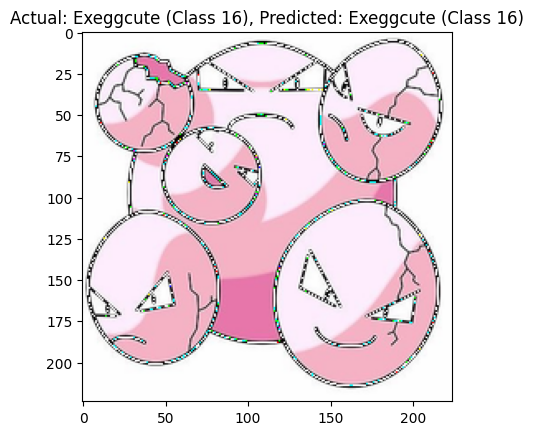

In [48]:
def display_random_image_prediction():
  index_to_display = random.randint(0, len(test_dataset) - 1)
  image, label = test_dataset[index_to_display]
  image = image.unsqueeze(0).to(device)
  logits = model(image.permute(0, 3, 1, 2))
  predicted_label = torch.argmax(logits).item()
  np_image = (image.squeeze().cpu().numpy() * 255).astype(np.uint8)
  np_image = 255 - np_image
  plt.imshow(np_image)
  plt.title(f"Actual: {pokemon_classes[label]} (Class {label}), Predicted: {pokemon_classes[predicted_label]} (Class {predicted_label})")
  plt.show()


display_random_image_prediction()
